In [1]:
import os
import torch
from model import replace_fc_layer, load_checkpoint
from mcunet.mcunet.model_zoo import build_model

In [10]:
model, optimizer = load_checkpoint("checkpoints/device_0_checkpoint.pth")
weight = model.classifier.weight.data

In [7]:
model2, resolution, description = build_model(net_id="mcunet-in3", pretrained=True)
model2 = replace_fc_layer(model2, 10)

In [2]:
model = load_checkpoint("./checkpoints/baseline_checkpoint_80.pth")


In [7]:
model.classifier

Sequential(
  (0): Linear(in_features=160, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
)

In [12]:
model2.classifier.weight.data = weight

In [13]:
model2.classifier.weight.data

tensor([[ 0.0512,  0.0375,  0.0081,  ..., -0.0418,  0.0016,  0.0161],
        [-0.0346, -0.0411, -0.0662,  ..., -0.0101,  0.0288,  0.0596],
        [ 0.0088,  0.0588, -0.0079,  ..., -0.0399,  0.0230,  0.0175],
        ...,
        [-0.0052, -0.0124, -0.0114,  ...,  0.0397, -0.0349,  0.0437],
        [-0.0549,  0.0351,  0.0417,  ..., -0.0242, -0.0100, -0.0258],
        [ 0.0423,  0.0002, -0.0330,  ...,  0.0102, -0.0125,  0.0076]])

In [11]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset, Dataset
from typing import List, Tuple
import torchvision
import torchvision.transforms as transforms

def _download_data(dataset_name: str):
    transform = transforms.Compose([transforms.ToTensor()])
    
    if dataset_name == "cifar10":
        trainset = torchvision.datasets.CIFAR10(root='./dataset', train=True, download=False, transform=transform)
        testset = torchvision.datasets.CIFAR10(root='./dataset', train=False, download=False, transform=transform)
    else:
        raise ValueError(f"Unsupported dataset: {dataset_name}")
    
    return trainset, testset

def partition_data_dirichlet(
    num_clients, alpha, batch_size, seed=42, dataset_name="cifar10"
) -> Tuple[List[DataLoader], DataLoader]:
    """Partition according to the Dirichlet distribution.

    Parameters
    ----------
    num_clients : int
        The number of clients that hold a part of the data
    alpha: float
        Parameter of the Dirichlet distribution
    batch_size: int
        Batch size for the data loaders
    seed : int, optional
        Used to set a fix seed to replicate experiments, by default 42
    dataset_name : str
        Name of the dataset to be used

    Returns
    -------
    Tuple[List[DataLoader], DataLoader]
        The list of data loaders for each client, the test data loader.
    """
    trainset, testset = _download_data(dataset_name)
    min_required_samples_per_client = 10
    min_samples = 0
    prng = np.random.default_rng(seed)

    # get the targets
    tmp_t = trainset.targets
    if isinstance(tmp_t, list):
        tmp_t = np.array(tmp_t)
    if isinstance(tmp_t, torch.Tensor):
        tmp_t = tmp_t.numpy()
    num_classes = len(set(tmp_t))
    total_samples = len(tmp_t)
    while min_samples < min_required_samples_per_client:
        idx_clients: List[List[int]] = [[] for _ in range(num_clients)]
        for k in range(num_classes):
            idx_k = np.where(tmp_t == k)[0]
            prng.shuffle(idx_k)
            proportions = prng.dirichlet(np.repeat(alpha, num_clients))
            proportions = np.array(
                [
                    p * (len(idx_j) < total_samples / num_clients)
                    for p, idx_j in zip(proportions, idx_clients)
                ]
            )
            proportions = proportions / proportions.sum()
            proportions = (np.cumsum(proportions) * len(idx_k)).astype(int)[:-1]
            idx_k_split = np.split(idx_k, proportions)
            idx_clients = [
                idx_j + idx.tolist() for idx_j, idx in zip(idx_clients, idx_k_split)
            ]
            min_samples = min([len(idx_j) for idx_j in idx_clients])

    trainsets_per_client = [Subset(trainset, idxs) for idxs in idx_clients]

    # Create data loaders for each client
    client_dataloaders = [DataLoader(dataset, batch_size=batch_size, shuffle=True) for dataset in trainsets_per_client]
    test_dataloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    return client_dataloaders, test_dataloader

# Example usage
num_clients = 20
alpha = 20
batch_size = 128

client_dataloaders, test_dataloader = partition_data_dirichlet(num_clients, alpha, batch_size)

# Print the number of samples for each client
for client_id, dataloader in enumerate(client_dataloaders):
    print(f"Client {client_id}: {len(dataloader.dataset)} samples")

Client 0: 2649 samples
Client 1: 2759 samples
Client 2: 2449 samples
Client 3: 2452 samples
Client 4: 2454 samples
Client 5: 2299 samples
Client 6: 2716 samples
Client 7: 2457 samples
Client 8: 2491 samples
Client 9: 2577 samples
Client 10: 2308 samples
Client 11: 2469 samples
Client 12: 2450 samples
Client 13: 2676 samples
Client 14: 2346 samples
Client 15: 2496 samples
Client 16: 2427 samples
Client 17: 2560 samples
Client 18: 2477 samples
Client 19: 2488 samples


In [1]:
from dataset import get_nonIID_dataloader
dataloaders = get_nonIID_dataloader("./dataset", train=True)


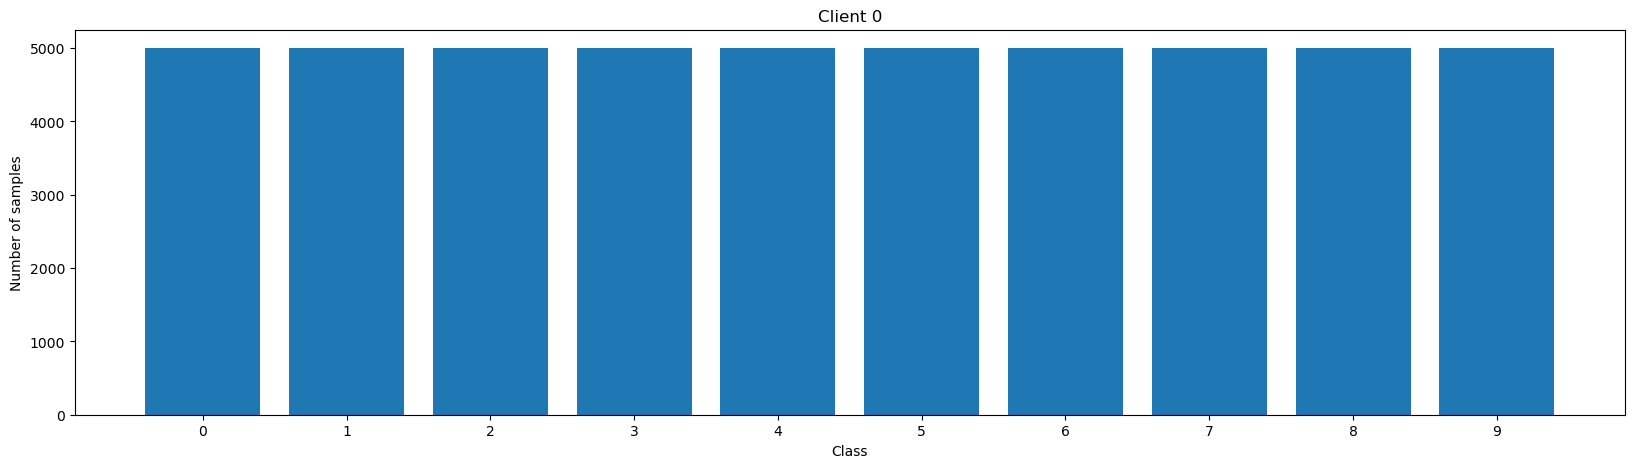

In [10]:
import matplotlib.pyplot as plt
from collections import defaultdict

"""Plot the class distribution for each client."""
num_clients = len(client_dataloaders)
class_counts = defaultdict(lambda: np.zeros(10))

for client_id, dataloader in enumerate(client_dataloaders):
    for _, targets in dataloader:
        for target in targets:
            class_counts[client_id][target.item()] += 1

fig, axes = plt.subplots(1, num_clients, figsize=(20, 5), sharey=True)
if num_clients == 1:
    axes = [axes]

for client_id, ax in enumerate(axes):
    ax.bar(range(10), class_counts[client_id])
    ax.set_title(f'Client {client_id}')
    ax.set_xlabel('Class')
    ax.set_ylabel('Number of samples')
    ax.set_xticks(range(10))

plt.show()

In [27]:
list = [1,4,2,4,6,7,3,61,6,8,29]
counter = 0
running_average = 0
for i in range(len(list)):
    counter += 1
    running_average = running_average + (list[i] - running_average) / counter
    print(running_average)
    print(np.mean(list[:i-len(list)+1]))
    print("__________________")




1.0
1.0
__________________
2.5
2.5
__________________
2.3333333333333335
2.3333333333333335
__________________
2.75
2.75
__________________
3.4
3.4
__________________
4.0
4.0
__________________
3.857142857142857
3.857142857142857
__________________
11.0
11.0
__________________
10.444444444444445
10.444444444444445
__________________
10.2
10.2
__________________
11.909090909090908
nan
__________________


c:\Users\Lance Bao\anaconda3\envs\HITL\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Lance Bao\anaconda3\envs\HITL\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [29]:
142  578 10  37/7

[]

In [ ]:
7/3 30/3 a+(b-a)/x = 37/7

In [33]:
[1,2,3] * 3

[1, 2, 3, 1, 2, 3, 1, 2, 3]

In [38]:
import matplotlib.pyplot as plt

acc = []
f1 = []
with open("result.txt", "r") as f:
    # read every line
    for line in f:
        # split the line into words
        words = line.split(', ')
        # convert the first word to an integer
        acc.append(float(words[1]))
        f1.append(float(words[2]))
        

{'whiskers': [<matplotlib.lines.Line2D at 0x1b424914e80>,
 'caps': [<matplotlib.lines.Line2D at 0x1b424926460>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b424914b80>,
 'medians': [<matplotlib.lines.Line2D at 0x1b424926a00>,
 'fliers': [<matplotlib.lines.Line2D at 0x1b424926cd0>,
 'means': []}

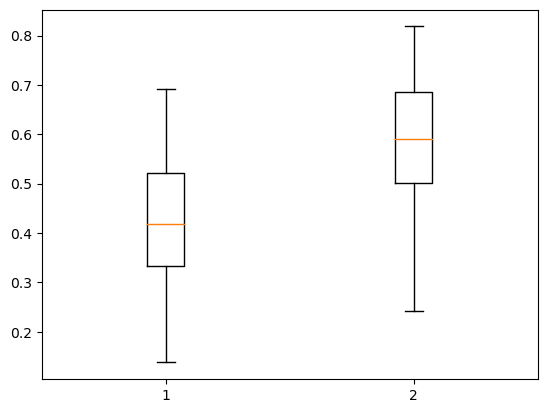

In [46]:
fig, ax = plt.subplots()
acc.sort()
f1.sort()
ax.boxplot([acc, f1])


(array([1., 3., 2., 4., 6., 9., 7., 9., 6., 3.]),
 array([0.2421 , 0.29972, 0.35734, 0.41496, 0.47258, 0.5302 , 0.58782,
        0.64544, 0.70306, 0.76068, 0.8183 ]),
 <BarContainer object of 10 artists>)

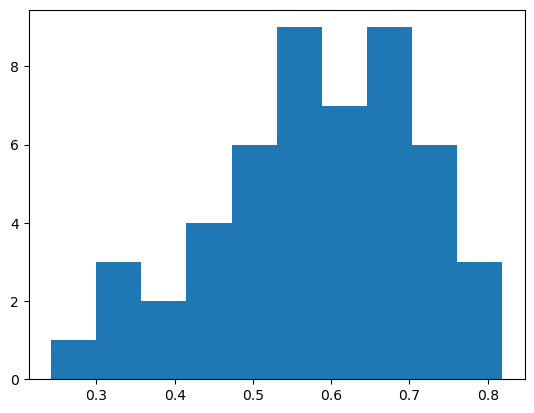

In [44]:
fig, ax = plt.subplots()
ax.hist(f1, bins=10)